In [71]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data visualizations

In [72]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


[Text(0.5, 0, 'Amount of occurrences')]

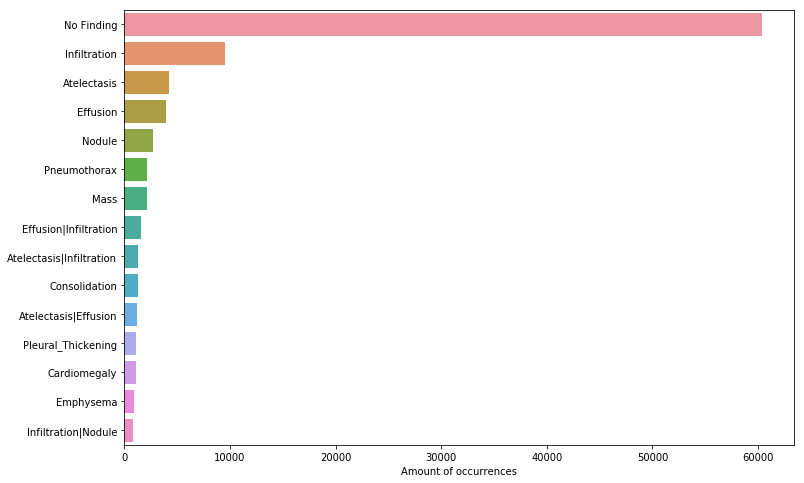

In [73]:
labels_count = df['Finding Labels'].value_counts()[:15]
plt.subplots(figsize=(12, 8))
ax = sns.barplot(labels_count, labels_count.index)
ax.set(xlabel='Amount of occurrences')

### Small label preparation

In [74]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
#y = xray_df['Finding Labels'].map(lambda x: x.replace('|', '')).unique()
#y = pd.Series(np.concatenate((df['Finding Labels'], [x.split('|') for x in df['Finding Labels']]), axis=0))
y = []
for x in df['Finding Labels'].unique():
    splitted = x.split('|')
    y = np.append(y, splitted)

y = [x for x in y if len(x) > 0]
y = np.unique(y)
print('All labels ({}): {}'.format(len(y), y))

All labels (14): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [75]:
for label in y:
    df[label] = df['Finding Labels'].map(lambda x: 1.0 if label in x else 0.0)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### More data visualizations

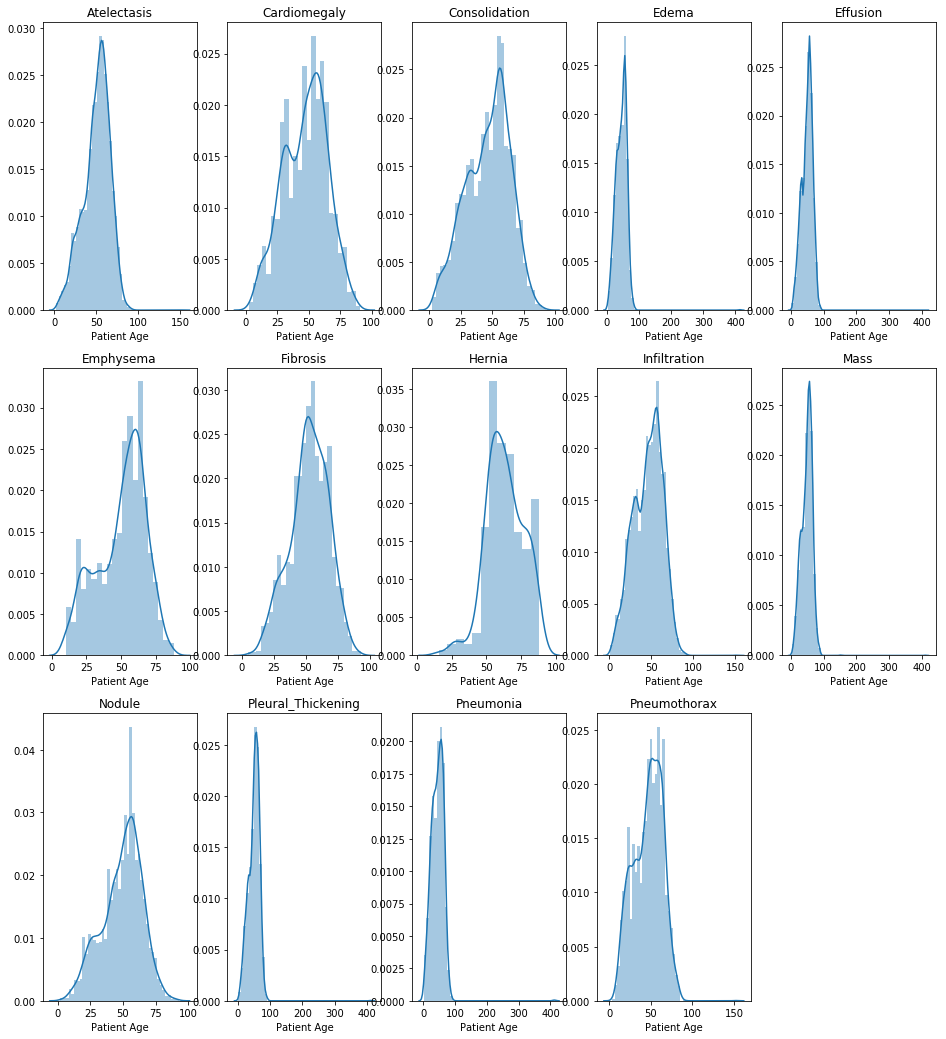

In [76]:
# Mean the patient ages for all labels
#ages = [df[df[label].where(df[label] == 1.0).notnull()]['Patient Age'].values.mean() for label in y]
plt.figure(figsize=(16, 18))
#sns.barplot(ages, y)
for i, column in enumerate(df[y]):
    plt.subplot(3, 5, i+1)
    plt.title(column)
    sns.distplot(df[df[column].where(df[column] == 1.0).notnull()]['Patient Age'])    

## Prepare the training data

This will store every result of the given data in one single vector. Basically, we store what the model will try to predict.

In [81]:
df['disease_vec'] = df.apply(lambda x: [x[y].values], 1).map(lambda x: x[0])
df['disease_vec'].head()

0    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
2    [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
Name: disease_vec, dtype: object

Now we are splitting our data in 20% test data and 80% training data.

In [78]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, stratify=df['Finding Labels'].map(lambda x: x[:4])) # function will return the 4 first character
print('train', train.shape[0], 'validation', validation.shape[0])

train 89696 validation 22424
